### Genotype Analysis

##### Create pipeline for proxy analysis of Syngap1 mutation

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import matplotlib.dates as mdates
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [27]:
# Load in local csv
folder = '/root/capsule/data/filtered_data_20240911/filtered_data_20240911.csv'
df = pd.read_csv(folder)

df.head()

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,water_after_session_last_session,location,session_name,creation_time,subject_genotype,probes,results,results_location,session_time,docDB_status
0,730942,2024-09-10,181826,14.0,447-3-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
1,741211,2024-09-10,181707,14.0,447-3-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_74...,behavior_741211_2024-09-10_18-17-07,2024-09-10T18:17:07-07:00,wt/wt,[],NaN,NaN,18-17-07,1_uploaded but not processed
2,736198,2024-09-10,181446,14.0,447-2-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_73...,behavior_736198_2024-09-10_18-14-46,2024-09-10T18:14:46-07:00,wt/wt,[],NaN,NaN,18-14-46,1_uploaded but not processed
3,730945,2024-09-10,181112,14.0,447-2-B,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
4,741213,2024-09-10,180831,14.0,447-2-A,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_74...,behavior_741213_2024-09-10_18-08-31,2024-09-10T18:08:31-07:00,wt/wt,[],NaN,NaN,18-08-31,1_uploaded but not processed


In [28]:
geno_df = df[['subject_id', 'subject_genotype', 'session_date','foraging_eff']]

geno_df = geno_df.sort_values(['subject_genotype', 'session_date'])

geno_df.head()

,subject_id,subject_genotype,session_date,foraging_eff
1348,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-10,0.714286
1321,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-11,0.705846
1298,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-12,0.505319
1212,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-20,0.779528
1187,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-21,0.673098


In [29]:
# Find all instances of unique subject ids
ids = geno_df['subject_id'].unique()
print(f'number of unique ids: {len(ids)}')

# Find total stage count
num_geno = geno_df['subject_genotype'].unique()
genos = geno_df['subject_genotype']

# Find total foraging efficiency value count 
forag_eff_count = geno_df['foraging_eff']

# Find total dates assigned per foraging efficiency score 
session_date_count = df['session_date'].unique()

print(f'types of genotypes: {num_geno}, number of total genotypes {len(genos)}')

print(f'number of assigned dates {len(session_date_count)}')

print(f'number of forag eff scores: {len(forag_eff_count)}')

number of unique ids: 183
types of genotypes: ['Ai148(TIT2L-GC6f-ICL-tTA2)/wt' 'Dbh-Cre-KI/wt'
 'Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-tTA2-WPRE)/wt'
 'Fos2A-iCreER/wt;Ai75(RCL-nT)/wt' 'Gad2-IRES-Cre/Gad2-IRES-Cre'
 'Oi8(H11-CAG-Cas9)/Oi8(H11-CAG-Cas9)' 'Pdyn-IRES-Cre/Pdyn-IRES-Cre'
 'Sert-Cre/wt' 'Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt' 'Slc32a1-IRES-Cre/wt'
 'Slc6a3-IRES-Cre_Bkmn/wt' 'VGAT-ChR2-YFP/wt' 'wt/wt' nan], number of total genotypes 3763
number of assigned dates 283
number of forag eff scores: 3763


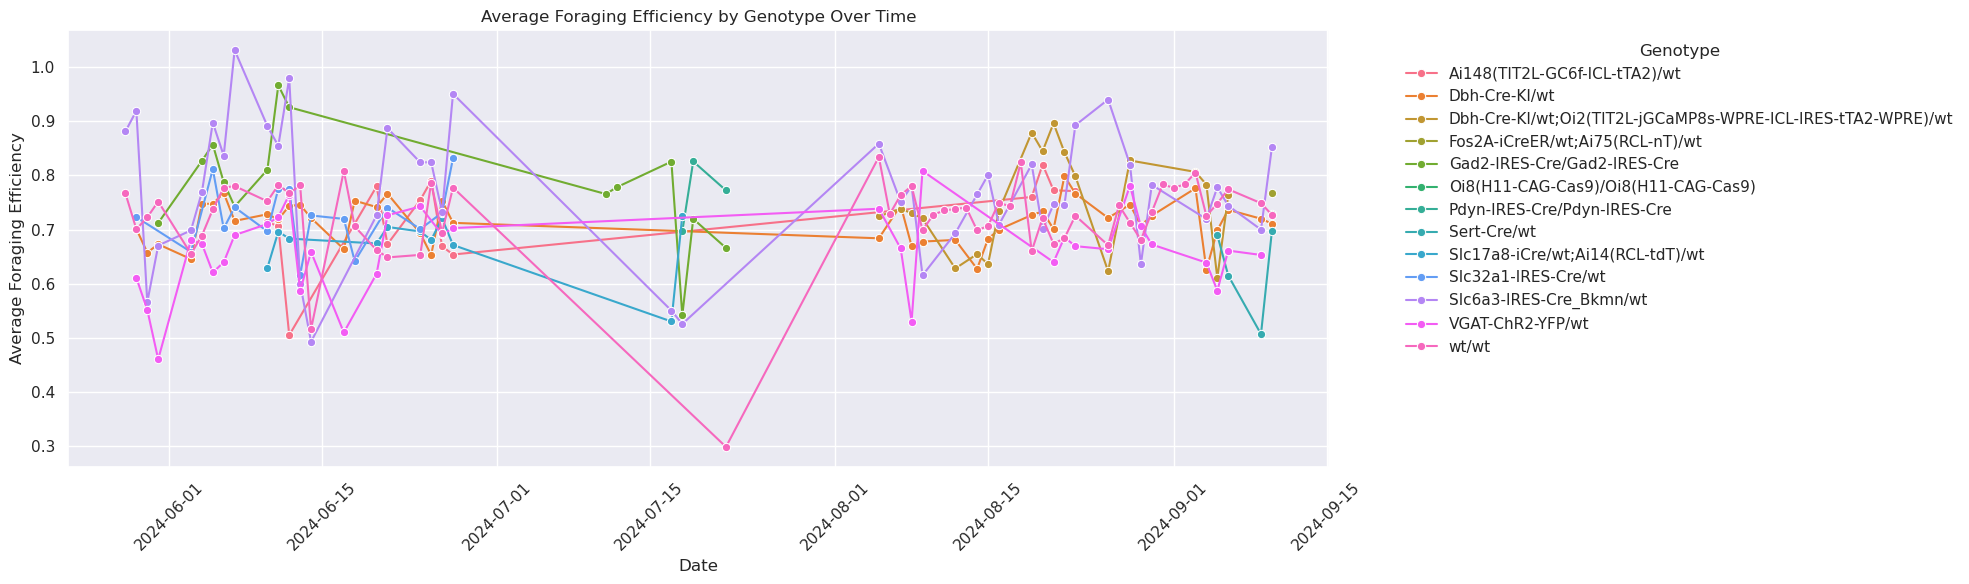

                                                    count      mean       std  \
subject_genotype                                                                
Ai148(TIT2L-GC6f-ICL-tTA2)/wt                        13.0  0.720680  0.082681   
Dbh-Cre-KI/wt                                        44.0  0.713916  0.040147   
Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-...   19.0  0.749528  0.089062   
Fos2A-iCreER/wt;Ai75(RCL-nT)/wt                       1.0  0.768072       NaN   
Gad2-IRES-Cre/Gad2-IRES-Cre                          14.0  0.780276  0.106144   
Oi8(H11-CAG-Cas9)/Oi8(H11-CAG-Cas9)                   1.0  0.728871       NaN   
Pdyn-IRES-Cre/Pdyn-IRES-Cre                           3.0  0.764816  0.064837   
Sert-Cre/wt                                           4.0  0.627429  0.088281   
Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt                     11.0  0.673968  0.054327   
Slc32a1-IRES-Cre/wt                                  16.0  0.724327  0.057402   
Slc6a3-IRES-Cre_Bkmn/wt     

In [34]:
# plot average foraging efficiency over time

# Sort the dataframe by date
geno_df = geno_df.sort_values('session_date', ascending=True)


# Group by genotype, date, and calculate mean foraging efficiency 
grouped_df = geno_df.groupby(['subject_genotype', 'session_date'])['foraging_eff'].mean().reset_index()


# Plot grouped dataframe 
sns.set_theme()
plt.figure(figsize=(20, 6))

sns.lineplot(data=grouped_df, x='session_date', y='foraging_eff', hue='subject_genotype', marker='o')

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='best', frameon=False)

plt.tight_layout()
plt.show()

print(grouped_df.groupby('subject_genotype')['foraging_eff'].describe())

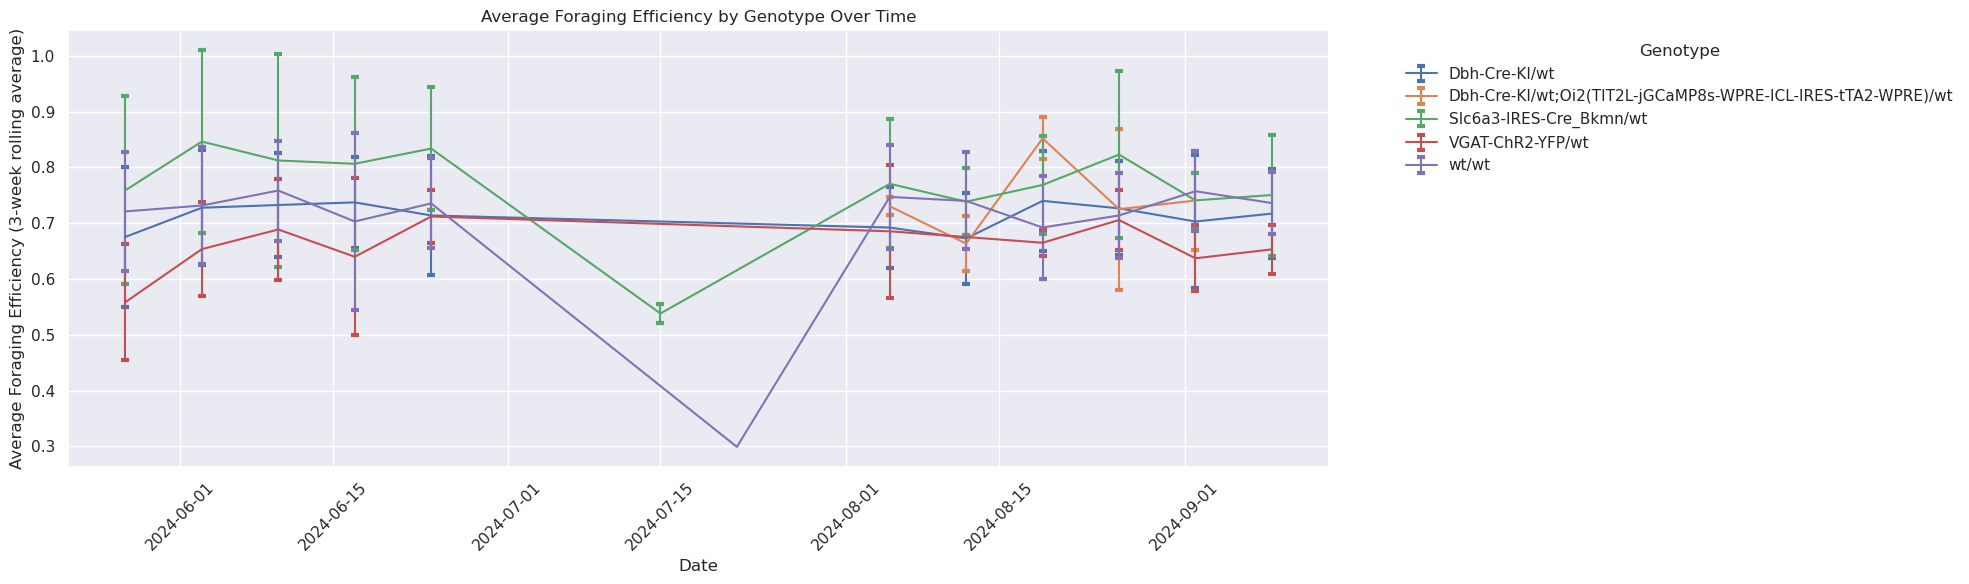

In [31]:
# Making a cleaner plot / add std

# Group by genotype and week
geno_df['session_date'] = pd.to_datetime(df['session_date'], errors='coerce')
geno_df['week'] = geno_df['session_date'].dt.to_period('W')
grouped_df = geno_df.groupby(['subject_genotype', 'week'])['foraging_eff'].agg(['mean', 'std']).reset_index() # Calculate mean foraging efficiency 
grouped_df['week'] = grouped_df['week'].dt.to_timestamp()


# Take only top 5 most common genotypes in df
top_n_genotypes = geno_df['subject_genotype'].value_counts().nlargest(5).index
grouped_df = grouped_df[grouped_df['subject_genotype'].isin(top_n_genotypes)]


# Plot dataframe
plt.figure(figsize=(20, 6))

# Plot average foraging efficiency for each genotype 
for genotype in grouped_df['subject_genotype'].unique():
    data = grouped_df[grouped_df['subject_genotype'] == genotype]
    plt.errorbar(data['week'], data['mean'], yerr=data['std'], label=genotype, capsize=3, capthick=3)

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency (3-week rolling average)')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='best', frameon = False)

plt.tight_layout()
plt.show()

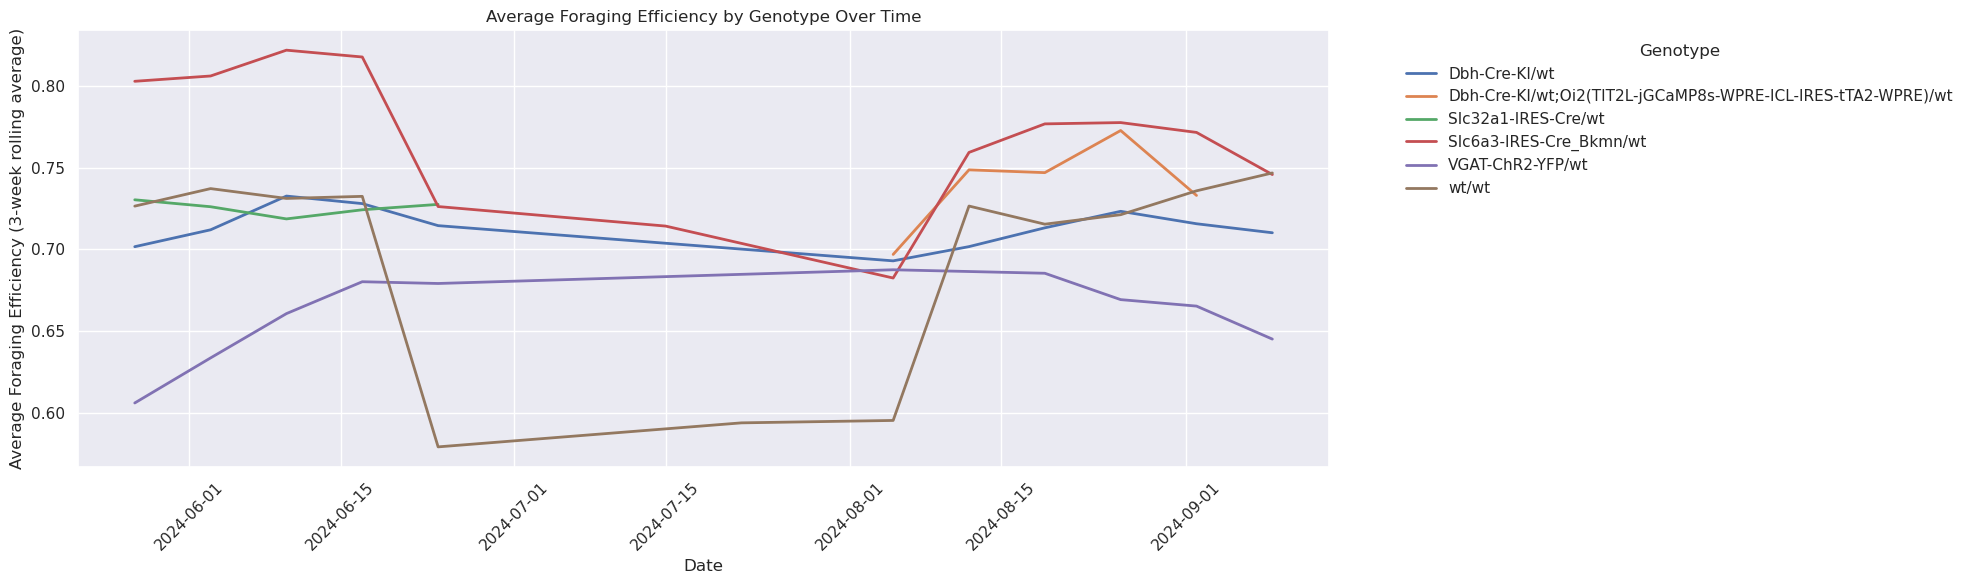

In [32]:

grouped_df = geno_df.groupby(['subject_genotype', 'week'])['foraging_eff'].mean().reset_index()
grouped_df['week'] = grouped_df['week'].dt.to_timestamp()

# Use 3-week rolling average
grouped_df = grouped_df.sort_values(['subject_genotype', 'week'])
grouped_df['rolling_avg'] = grouped_df.groupby('subject_genotype')['foraging_eff'].rolling(window=3, center=True, min_periods=1).mean().reset_index(0, drop=True)


top_n_genotypes = geno_df['subject_genotype'].value_counts().nlargest(6).index
grouped_df = grouped_df[grouped_df['subject_genotype'].isin(top_n_genotypes)]


plt.figure(figsize=(20, 6))

sns.lineplot(data=grouped_df, x='week', y='rolling_avg', hue='subject_genotype', linewidth=2, errorbar='sd')

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency (3-week rolling average)')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False)

plt.tight_layout()
plt.show()